In [53]:
%matplotlib inline


In [54]:
import numpy as np
print(np.__version__)


2.2.5


In [55]:
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor


In [56]:
# 设置设备：如果你安装的是 CUDA 版本的 PyTorch，会自动用 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 模型路径（请确认 sam_vit_b_01ec64.pth 跟 notebook 文件在同一目录）
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

In [57]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [58]:
# 初始化预测器对象（之后用于图像分割）
predictor = SamPredictor(sam)

print("Segment Anything ready")

Segment Anything ready


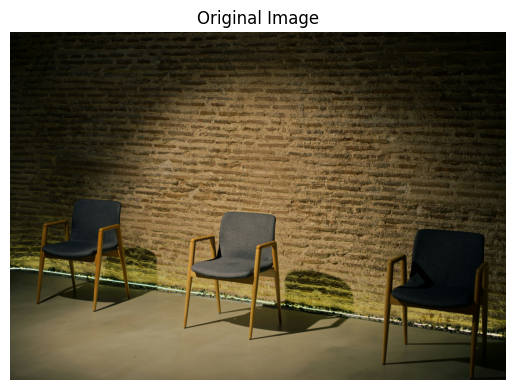

In [59]:
image_path = "D:\cci 2025\segmentation\chair (1).jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

predictor.set_image(image)

In [60]:
# 计算图像中心作为提示点
h, w, _ = image.shape
input_point = np.array([[w // 2, h // 2]])
input_label = np.array([1])  # 1 表示正样本提示（foreground）

print(h, w)
print(input_point)


5178 7371
[[3685 2589]]


In [61]:
# 使用 SAM 模型进行分割
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

# 提取第一张 mask（布尔数组）
mask = masks[0]


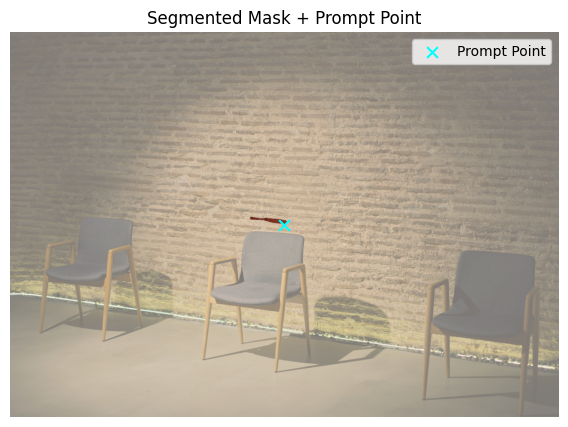

In [62]:
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')  # 更鲜明的红色遮罩

# 在图像中心画红点表示 prompt
plt.scatter([w // 2], [h // 2], color='cyan', s=60, marker='x', label='Prompt Point')

plt.title("Segmented Mask + Prompt Point")
plt.legend()
plt.axis('off')
plt.show()



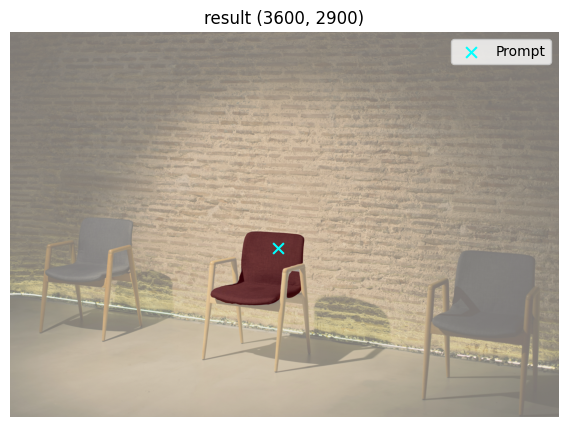

In [65]:
#手动指定椅子上的坐标
x, y = 3600, 2900  # ← 你可以根据图像修改成椅子中心的位置

input_point = np.array([[x, y]])
input_label = np.array([1])  # foreground

# 运行 SAM 分割
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

mask = masks[0]

# 可视化结果
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.scatter([x], [y], color='cyan', s=60, marker='x', label='Prompt')
plt.title(f"result ({x}, {y})")
plt.legend()
plt.axis('off')
plt.show()


In [67]:
def compute_brightness(region):
    """
    region: shape (N, 3), RGB pixel array
    return: average perceived brightness
    """
    r, g, b = region[:, 0], region[:, 1], region[:, 2]
    return np.mean(0.2126 * r + 0.7152 * g + 0.0722 * b)

# 1. Extract chair pixels from the mask (mask == True)
mask_bool = mask.astype(bool)
chair_pixels = image[mask_bool]

# 2. Extract background pixels (mask == False)
background_pixels = image[~mask_bool]

# 3. Compute average brightness
chair_brightness = compute_brightness(chair_pixels)
background_brightness = compute_brightness(background_pixels)

# 4. Compute brightness contrast
contrast = abs(chair_brightness - background_brightness)

# 5. Print result
print(f"Chair brightness: {chair_brightness:.2f}")
print(f"Background brightness: {background_brightness:.2f}")
print(f"Brightness contrast: {contrast:.2f}")

# 6. Threshold for visual distinction
contrast_threshold = 20
if contrast > contrast_threshold:
    print("The chair stands out clearly from the background.")
else:
    print("The chair blends into the background.")



Chair brightness: 89.77
Background brightness: 69.46
Brightness contrast: 20.31
The chair stands out clearly from the background.


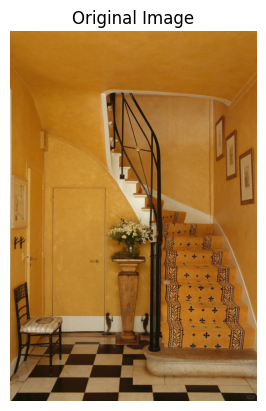

In [68]:
image2_path = "D:\cci 2025\segmentation\chair (2).jpg"

image2 = cv2.imread(image2_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.imshow(image2)
plt.axis('off')
plt.title("Original Image")
plt.show()

predictor.set_image(image2)

In [69]:
# 计算图像中心作为提示点
h, w, _ = image2.shape
input_point = np.array([[w // 2, h // 2]])
input_label = np.array([1])  # 1 表示正样本提示（foreground）

print(h, w)
print(input_point)


1620 1080
[[540 810]]


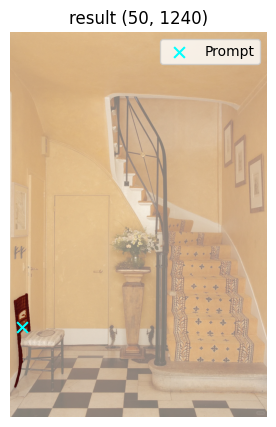

In [70]:
#手动指定椅子上的坐标
x, y = 50, 1240  # ← 你可以根据图像修改成椅子中心的位置

input_point = np.array([[x, y]])
input_label = np.array([1])  # foreground

# 运行 SAM 分割
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

mask = masks[0]

# 可视化结果
plt.figure(figsize=(10, 5))
plt.imshow(image2)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.scatter([x], [y], color='cyan', s=60, marker='x', label='Prompt')
plt.title(f"result ({x}, {y})")
plt.legend()
plt.axis('off')
plt.show()


In [71]:
def compute_brightness(region):
    """
    region: shape (N, 3), RGB pixel array
    return: average perceived brightness
    """
    r, g, b = region[:, 0], region[:, 1], region[:, 2]
    return np.mean(0.2126 * r + 0.7152 * g + 0.0722 * b)

# 1. Extract chair pixels from the mask (mask == True)
mask_bool = mask.astype(bool)
chair_pixels = image2[mask_bool]

# 2. Extract background pixels (mask == False)
background_pixels = image2[~mask_bool]

# 3. Compute average brightness
chair_brightness = compute_brightness(chair_pixels)
background_brightness = compute_brightness(background_pixels)

# 4. Compute brightness contrast
contrast = abs(chair_brightness - background_brightness)

# 5. Print result
print(f"Chair brightness: {chair_brightness:.2f}")
print(f"Background brightness: {background_brightness:.2f}")
print(f"Brightness contrast: {contrast:.2f}")

# 6. Threshold for visual distinction
contrast_threshold = 20
if contrast > contrast_threshold:
    print("The chair stands out clearly from the background.")
else:
    print("The chair blends into the background.")

Chair brightness: 44.15
Background brightness: 113.70
Brightness contrast: 69.55
The chair stands out clearly from the background.
